In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedabdelaziz984","key":"934af947a66c35c191029c498d07ea7b"}'}

In [5]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!pip install kagglehub

In [7]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
 99% 3.71G/3.75G [00:06<00:00, 638MB/s] 
100% 3.75G/3.75G [00:07<00:00, 568MB/s]


In [8]:
!unzip -q 140k-real-and-fake-faces.zip

 IMAGE DEEPFAKE DETECTION WITH ENHANCED VGG16

 TensorFlow version: 2.18.0
 GPU Available: /physical_device:GPU:0

 Loading dataset metadata...

 Dataset Statistics:
Training:   100,000 samples (Real: 50,000, Fake: 50,000)
Validation: 20,000 samples (Real: 10,000, Fake: 10,000)
Test:       20,000 samples (Real: 10,000, Fake: 10,000)

 Creating data generators...

  Building Enhanced VGG16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model Statistics:
Total parameters:     14,880,577
Trainable parameters: 165,121

Phase 1: Training with frozen VGG16 base...
Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6244 - auc: 0.6682 - loss: 4.7945 - precision: 0.6333 - recall: 0.5921
Epoch 1: val_loss improved from inf to 2.47887, saving model to best_deepfake_model_phase1.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3316s 2s/step - accuracy: 0.6244 - auc: 0.6683 - loss: 4.7940 - precision: 0.6333 - recall: 0.5921 - val_accuracy: 0.7580 - val_auc: 0.8482 - val_loss: 2.4

Predicting: 100%|██████████| 313/313 [01:18<00:00,  3.97it/s]



 Test Results:
Accuracy:  0.9804
Precision: 0.9831
Recall:    0.9776
F1-Score:  0.9803
AUC-ROC:   0.9980


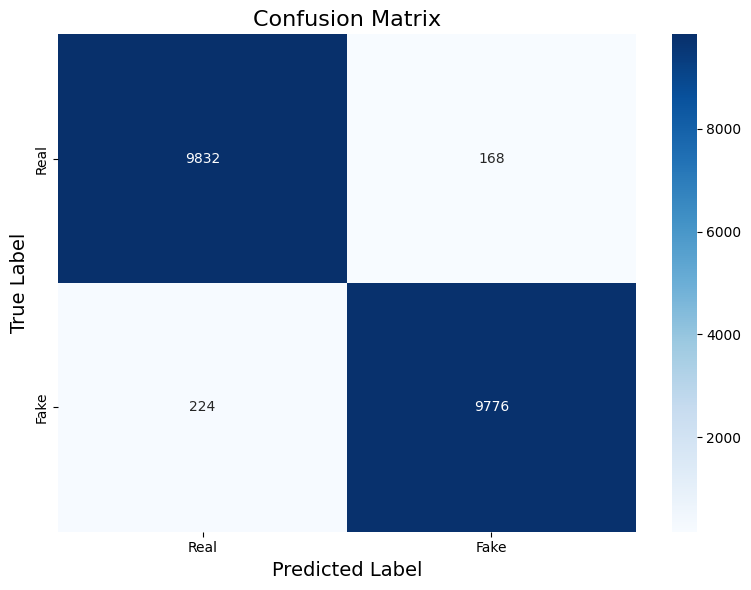

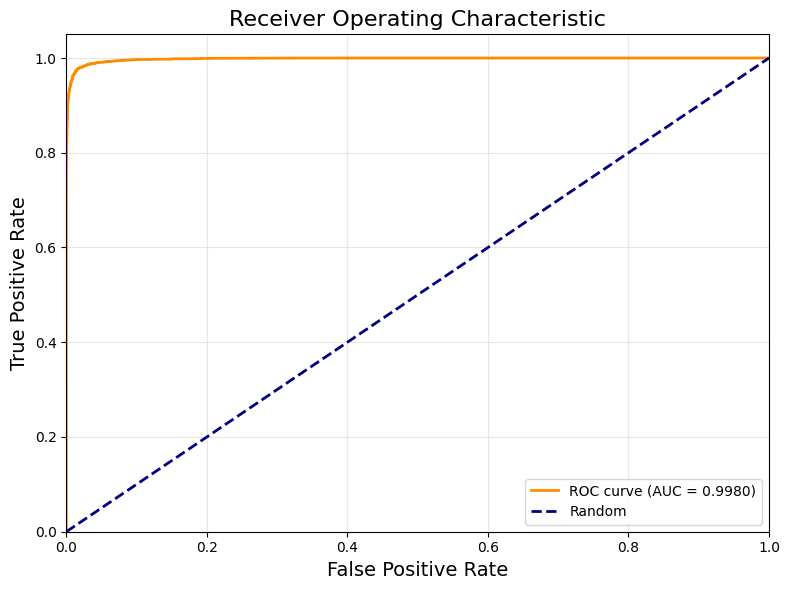


 Classification Report:
              precision    recall  f1-score   support

        Real     0.9777    0.9832    0.9805     10000
        Fake     0.9831    0.9776    0.9803     10000

    accuracy                         0.9804     20000
   macro avg     0.9804    0.9804    0.9804     20000
weighted avg     0.9804    0.9804    0.9804     20000



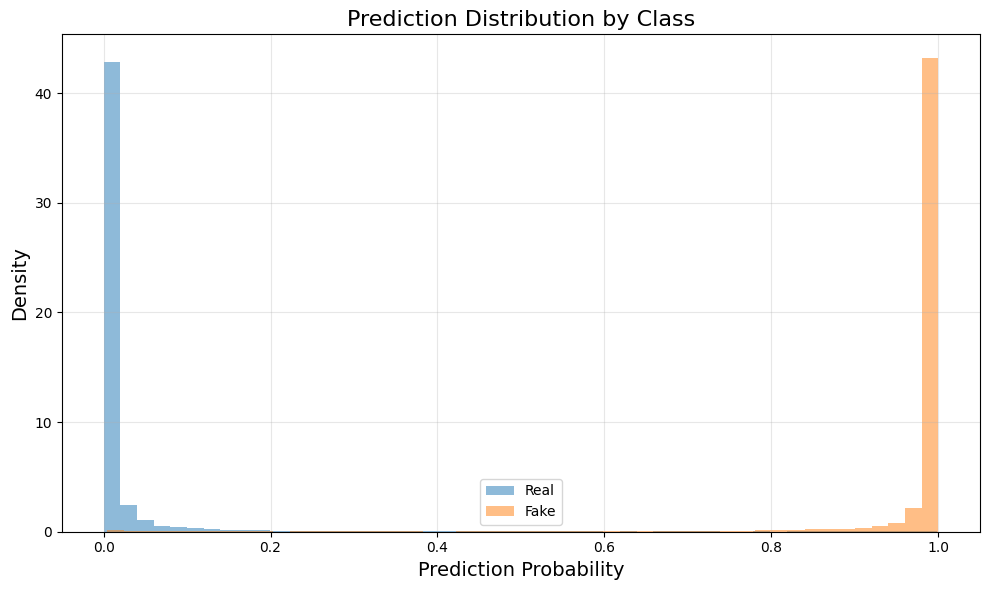

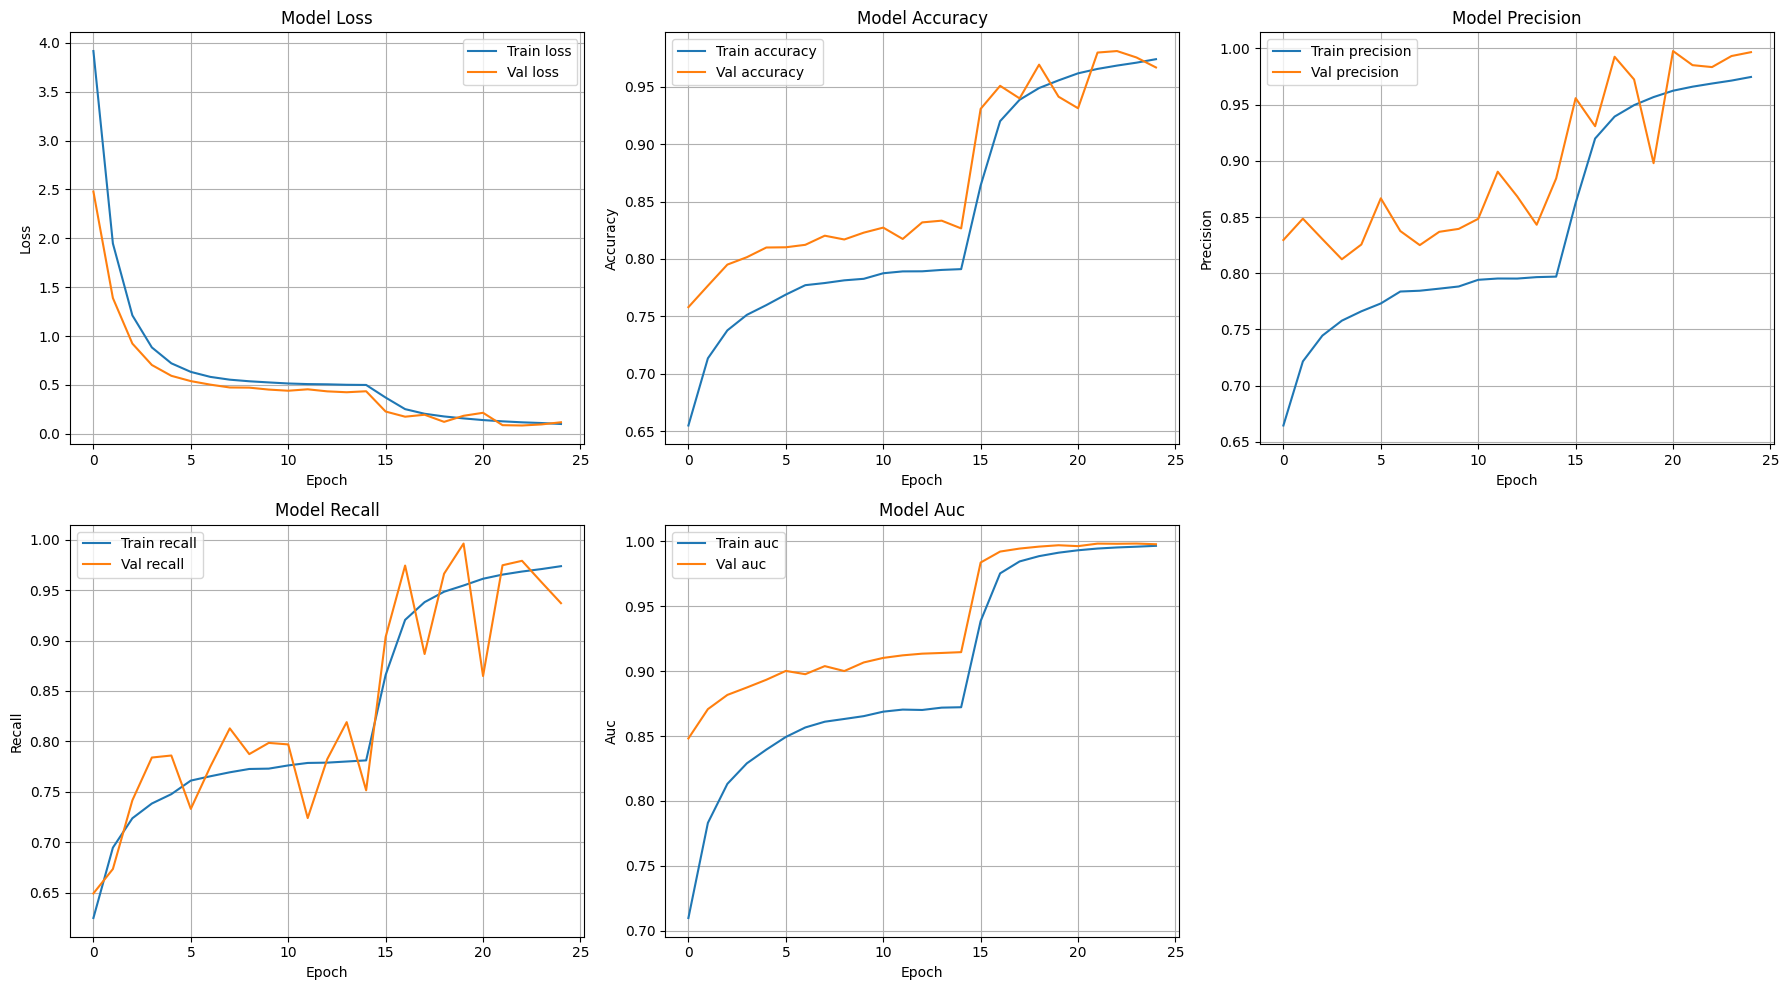


 All done! Results saved:
   - Model: 'best_deepfake_model_final.keras'
   - Results: 'deepfake_detection_results.txt'
   - Plots: 'training_history_complete.png', 'confusion_matrix.png', 'roc_curve.png', 'prediction_distribution.png'


In [9]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Base paths
BASE_DATA_PATH = "."
IMAGE_DIR = os.path.join(BASE_DATA_PATH, "real_vs_fake", "real-vs-fake")

# Model hyperparameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
INITIAL_EPOCHS = 15
FINETUNE_EPOCHS = 10
INITIAL_LR = 1e-4  # Lower initial learning rate
FINETUNE_LR = 1e-5

# Enable mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')


class DeepfakeDataGenerator(tf.keras.utils.Sequence):
    """Custom data generator with proper VGG16 preprocessing"""

    def __init__(self, df, image_dir, batch_size=32, image_size=(224, 224),
                 shuffle=True, augment=False):
        self.df = df.copy()
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.df))

        # Data augmentation
        self.augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
            tf.keras.layers.RandomBrightness(0.2),
            tf.keras.layers.RandomContrast(0.2),
        ]) if augment else None

        if shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indices]

        images = []
        labels = []

        for _, row in batch_df.iterrows():
            # Load image
            img_path = os.path.join(self.image_dir, row['path'])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.image_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            # Apply augmentation if enabled
            if self.augment and self.augmentation:
                img_array = self.augmentation(img_array)

            # Apply VGG16 preprocessing
            img_array = preprocess_input(img_array)

            images.append(img_array)
            labels.append(row['label'])

        return np.array(images), np.array(labels, dtype=np.float32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


def create_enhanced_vgg16_model(input_shape, num_classes=1):
    """Create an enhanced VGG16 model for deepfake detection"""

    # Load pre-trained VGG16
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model initially
    base_model.trainable = False

    # Build the model
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Custom classifier head with regularization
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(num_classes, activation='sigmoid', dtype='float32')(x)  # Ensure float32 output

    model = Model(inputs, outputs)
    return model, base_model


def create_callbacks(model_name="best_deepfake_model.keras"):
    """Create training callbacks"""
    callbacks = [
        ModelCheckpoint(
            model_name,
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]
    return callbacks


def plot_training_history(history):
    """Plot training history with all metrics"""
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()

    for idx, metric in enumerate(metrics):
        if metric in history.history:
            axes[idx].plot(history.history[metric], label=f'Train {metric}')
            axes[idx].plot(history.history[f'val_{metric}'], label=f'Val {metric}')
            axes[idx].set_title(f'Model {metric.capitalize()}')
            axes[idx].set_xlabel('Epoch')
            axes[idx].set_ylabel(metric.capitalize())
            axes[idx].legend()
            axes[idx].grid(True)

    # Remove empty subplot
    fig.delaxes(axes[5])

    plt.tight_layout()
    plt.savefig('training_history_complete.png', dpi=300, bbox_inches='tight')
    plt.show()


def evaluate_model(model, test_generator, test_df):
    """Comprehensive model evaluation"""

    print("\n Evaluating model on test set...")

    # Get predictions
    predictions = []
    true_labels = []

    for i in tqdm(range(len(test_generator)), desc="Predicting"):
        images, labels = test_generator[i]
        preds = model.predict(images, verbose=0)
        predictions.extend(preds.flatten())
        true_labels.extend(labels)

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Convert probabilities to binary predictions
    binary_predictions = (predictions > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, binary_predictions)
    precision = precision_score(true_labels, binary_predictions, zero_division=0)
    recall = recall_score(true_labels, binary_predictions, zero_division=0)
    f1 = f1_score(true_labels, binary_predictions, zero_division=0)

    # Handle AUC calculation
    try:
        auc = roc_auc_score(true_labels, predictions)
    except:
        auc = 0.5

    print(f"\n Test Results:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, binary_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ROC Curve
    if auc > 0.5:
        fpr, tpr, _ = roc_curve(true_labels, predictions)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title('Receiver Operating Characteristic', fontsize=16)
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Classification Report
    print("\n Classification Report:")
    print(classification_report(true_labels, binary_predictions,
                              target_names=['Real', 'Fake'], digits=4))

    # Prediction distribution
    plt.figure(figsize=(10, 6))
    plt.hist(predictions[true_labels == 0], bins=50, alpha=0.5, label='Real', density=True)
    plt.hist(predictions[true_labels == 1], bins=50, alpha=0.5, label='Fake', density=True)
    plt.xlabel('Prediction Probability', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title('Prediction Distribution by Class', fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('prediction_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc,
        'predictions': predictions,
        'true_labels': true_labels,
        'confusion_matrix': cm
    }


def main():
    """Main training pipeline"""

    print("=" * 70)
    print(" IMAGE DEEPFAKE DETECTION WITH ENHANCED VGG16")
    print("=" * 70)

    # Check environment
    print(f"\n TensorFlow version: {tf.__version__}")
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f" GPU Available: {gpus[0].name}")
        # Configure GPU memory growth
        try:
            tf.config.experimental.set_memory_growth(gpus[0], True)
        except:
            pass
    else:
        print("  No GPU detected - training will be slower")

    # Load data
    print("\n Loading dataset metadata...")
    train_df = pd.read_csv(os.path.join(BASE_DATA_PATH, "train.csv"))
    valid_df = pd.read_csv(os.path.join(BASE_DATA_PATH, "valid.csv"))
    test_df = pd.read_csv(os.path.join(BASE_DATA_PATH, "test.csv"))

    # Dataset statistics
    print(f"\n Dataset Statistics:")
    print(f"Training:   {len(train_df):,} samples (Real: {(train_df['label']==0).sum():,}, Fake: {(train_df['label']==1).sum():,})")
    print(f"Validation: {len(valid_df):,} samples (Real: {(valid_df['label']==0).sum():,}, Fake: {(valid_df['label']==1).sum():,})")
    print(f"Test:       {len(test_df):,} samples (Real: {(test_df['label']==0).sum():,}, Fake: {(test_df['label']==1).sum():,})")

    # Create data generators
    print("\n Creating data generators...")
    train_generator = DeepfakeDataGenerator(
        train_df, IMAGE_DIR, BATCH_SIZE, IMAGE_SIZE, shuffle=True, augment=True
    )
    val_generator = DeepfakeDataGenerator(
        valid_df, IMAGE_DIR, BATCH_SIZE, IMAGE_SIZE, shuffle=False, augment=False
    )
    test_generator = DeepfakeDataGenerator(
        test_df, IMAGE_DIR, BATCH_SIZE, IMAGE_SIZE, shuffle=False, augment=False
    )

    # Build model
    print("\n  Building Enhanced VGG16 model...")
    model, base_model = create_enhanced_vgg16_model(IMAGE_SIZE + (3,))

    # Compile with appropriate metrics
    model.compile(
        optimizer=Adam(learning_rate=INITIAL_LR),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    print(f"\nModel Statistics:")
    print(f"Total parameters:     {model.count_params():,}")
    print(f"Trainable parameters: {sum(tf.keras.backend.count_params(w) for w in model.trainable_weights):,}")

    # Phase 1: Train with frozen base
    print("\nPhase 1: Training with frozen VGG16 base...")
    callbacks = create_callbacks("best_deepfake_model_phase1.keras")

    history1 = model.fit(
        train_generator,
        epochs=INITIAL_EPOCHS,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )

    # Phase 2: Fine-tuning
    print("\n Phase 2: Fine-tuning top layers of VGG16...")

    # Unfreeze top layers
    base_model.trainable = True
    fine_tune_at = 15  # Fine-tune from block5 onwards

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=FINETUNE_LR),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    print(f"Fine-tuning {len(base_model.layers) - fine_tune_at} layers")

    callbacks = create_callbacks("best_deepfake_model_final.keras")

    history2 = model.fit(
        train_generator,
        epochs=INITIAL_EPOCHS + FINETUNE_EPOCHS,
        initial_epoch=len(history1.history['loss']),
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )

    # Combine histories
    history = history1
    for key in history2.history:
        history.history[key].extend(history2.history[key])

    print("\n Training completed!")

    # Load best model and evaluate
    print("\nLoading best model for evaluation...")
    best_model = tf.keras.models.load_model("best_deepfake_model_final.keras")

    # Evaluate on test set
    results = evaluate_model(best_model, test_generator, test_df)

    # Plot complete training history
    plot_training_history(history)

    # Save results
    with open('deepfake_detection_results.txt', 'w') as f:
        f.write("Image Deepfake Detection Results\n")
        f.write("=" * 50 + "\n")
        f.write(f"Model: Enhanced VGG16 with Fine-tuning\n")
        f.write(f"Total Epochs: {INITIAL_EPOCHS + FINETUNE_EPOCHS}\n")
        f.write("-" * 50 + "\n")
        f.write(f"Test Accuracy:  {results['accuracy']:.4f}\n")
        f.write(f"Test Precision: {results['precision']:.4f}\n")
        f.write(f"Test Recall:    {results['recall']:.4f}\n")
        f.write(f"Test F1-Score:  {results['f1_score']:.4f}\n")
        f.write(f"Test AUC-ROC:   {results['auc_roc']:.4f}\n")
        f.write("-" * 50 + "\n")
        f.write(f"Confusion Matrix:\n")
        f.write(f"True Negatives:  {results['confusion_matrix'][0, 0]}\n")
        f.write(f"False Positives: {results['confusion_matrix'][0, 1]}\n")
        f.write(f"False Negatives: {results['confusion_matrix'][1, 0]}\n")
        f.write(f"True Positives:  {results['confusion_matrix'][1, 1]}\n")

    print("\n All done! Results saved:")
    print("   - Model: 'best_deepfake_model_final.keras'")
    print("   - Results: 'deepfake_detection_results.txt'")
    print("   - Plots: 'training_history_complete.png', 'confusion_matrix.png', 'roc_curve.png', 'prediction_distribution.png'")

    return model, results


if __name__ == "__main__":
    try:
        model, results = main()
    except Exception as e:
        print(f"\n ERROR: {e}")
        raise